# Getting Colors of Player Jerseys

In [1]:
import numpy as np
import cv2
import os
from random import randint 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import extcolors
from colormap import rgb2hex
from colormap import hex2rgb
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.keras.models import load_model 

## Function to get a random hit frame from the match to determine jersey colors

In [14]:
def getHitFrame(file_video,file_timestamps): 
    video = cv2.VideoCapture(file_video) 
    fps = video.get(cv2.CAP_PROP_FPS)
    print('frames per second =',fps) 
    with open(file_timestamps,'r') as f: 
        timestamps = f.read().split(',')  
        n = randint(0, len(timestamps)) 
        frame_id = int(fps*float(timestamps[n]))
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_id) 
        success, frame = video.read() 
        if success:     
            framepath = os.path.join('data','masked','base.jpg')
            cv2.imwrite(framepath, frame)
            print(f'\t Saved frame')

In [15]:
file_video = os.path.join('data','match1.mp4') 
file_timestamps = os.path.join('timestamps.txt') 

getHitFrame(file_video, file_timestamps)

frames per second = 30.0
	 Saved frame


## Function to Convert RGB into Hex and Create and DataFrame 

In [2]:
# Convert colors into hex and create a dataframe

def color_to_df(input2):
    colors_pre_list = str(input2).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['hex_code','occurence'])
    return df

1. **Tolerance** : 0 means no grouping and 100 means all colors are grouped
2. **Limit** : upper limit to the number of extracted colors presented in the output.

## Function to Obtain Court Area using Masking

In [3]:
def masking_image(input_image, BL, BR, TR, TL, saved_name):

    # mask defaulting to black for 3-channel and transparent for 4-channel
    # (of course replace corners with yours)
    mask = np.zeros(input_image.shape, dtype=np.uint8)
    roi_corners = np.array([[BL, BR, TR, TL]], dtype=np.int32)

    # fill the ROI so it doesn't get wiped out when the mask is applied
    channel_count = input_image.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)

    # apply the mask
    masked_image = cv2.bitwise_and(input_image, mask)

    # save the result
    cv2.imwrite(saved_name, masked_image)

    # Show the resulting image
    cv2.imshow("Masked Image", masked_image)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Function to Extract colors of player clothes and Plot a Donut graph

In [4]:
def exact_least_used_colors(input_image, tolerance, limit, zoom, num_rows): 
    
    # input_image is the masked image
    img = Image.open(input_image)
    
    # Extract colors - RGB, counts and create dataframe
    img_url = input_image
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = limit)
    df_color = color_to_df(colors_x)
    
    # We don't want black color of the background and green color of the court, so filter out first 2 rows
    list_color = list(df_color.iloc[2:,0])
    list_occurence = [int(i) for i in list(df_color.iloc[2:,1])]
    
    # annotate text
    text_c = [c + ' ' + str(round(p*100/sum(list_occurence),1)) +'%' for c, p in zip(list_color, list_occurence)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    # donut plot with percentages
    wedges, text = ax1.pie(list_occurence,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    # add image in the center of donut plot
    img = mpimg.imread(input_image)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    # Convert number of occurences into percentages
    list_percentage = []
    for p in list_occurence:
        p = round(p*100/sum(list_occurence),1)
        list_percentage.append(p)
        
    # second most occuring color: color of the player's clothes: df_player_color
    # df contains all colors except black bg and the green color of the court
    df = pd.DataFrame(zip(list_color, list_percentage), columns = ['Hex_Code','Percentage'])
    df_player_color = df.iloc[1,:]
    
    # Print RGB value of least used colors
    RGB_Value = [hex2rgb(df_player_color['Hex_Code'])]
    print("RGB Values: ", RGB_Value)
        
    # Display color palette
    RGB_Value = np.array(RGB_Value)[np.newaxis, :, :]
    plt.imshow(RGB_Value)
    plt.axis('off')
    plt.show()
    
    return RGB_Value[0][0]

## Implementing to get player colors

In [5]:
# Function to draw pure black lines on court left and right court boundaries (to improve particle filter) 

def change_court_boundary(frame): 
    
    # Boundary Points
    BL = (195,654)
    BR = (1068,654)
    TR = (848,275)
    TL = (398,275) 

    # Left Boundary Lines
    cv2.line(frame, BL,TL, (0,0,0), 7)  # Outer 
    cv2.line(frame, (BL[0] + 70, BL[1]),(TL[0] + 35, TL[1]), (0,0,0), 7)  # Inner   

    # Right Boundary Lines 
    cv2.line(frame, BR,TR, (0,0,0), 7)  # Inner 
    cv2.line(frame, (BR[0] - 70, BR[1]),(TR[0] - 35, TR[1]), (0,0,0), 7)  # Outer    
    
    # Center Line 
    cv2.line(frame, (BL[0] + int((BR[0] - BL[0])/2), BR[1]),(TR[0] - int((TR[0] - TL[0])/2), TR[1]), (0,0,0), 7) 

    return frame 

In [6]:
# original image
# -1 loads as-is so if it will be 3 or 4 channel as the original
IMAGE_PATH = os.path.join('data','masked', 'base.jpg')
image = cv2.imread(IMAGE_PATH, -1) 

In [7]:
image.shape

(720, 1280, 3)

In [8]:
MASKED_IMAGES = os.path.join('data','masked') 

RGB Values:  [(96, 0, 27)]


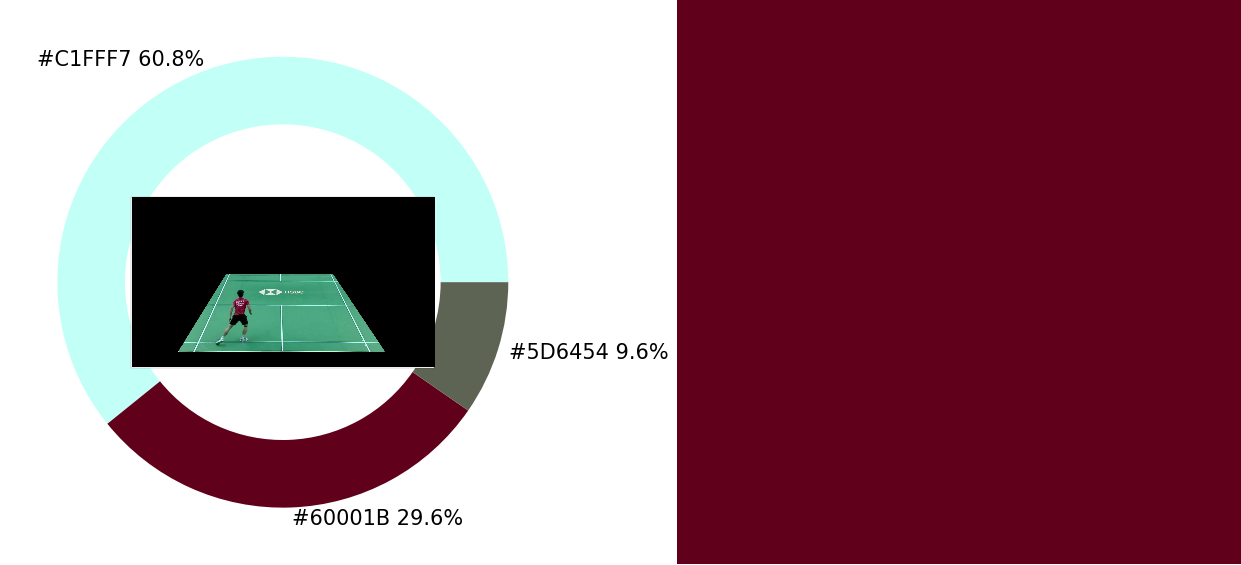

In [9]:
# For Lower Player
masking_image(image, (195,654), (1068,654), (848,325), (398,325), os.path.join(MASKED_IMAGES,'Masked_Lower.jpg'))
rgb_lower = exact_least_used_colors(os.path.join(MASKED_IMAGES,'Masked_Lower.jpg'),36, 10, 1.7, 5)

RGB Values:  [(195, 253, 239)]


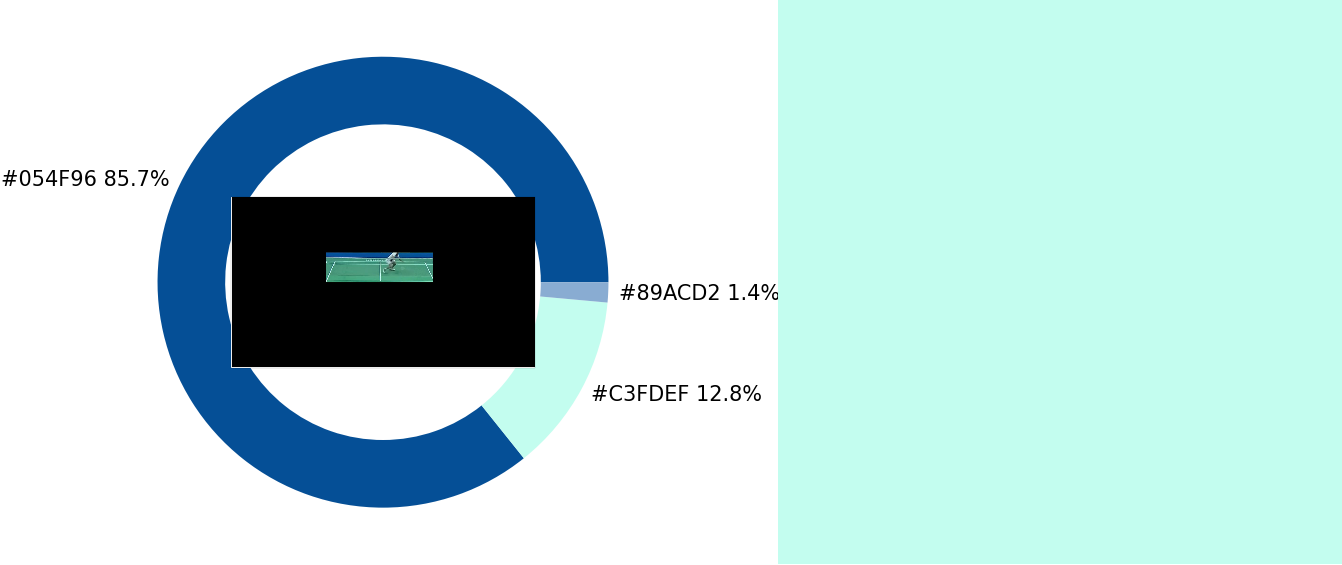

In [10]:
# For Upper Player
masking_image(image, (398,360), (848,360), (848,235), (398,235), os.path.join(MASKED_IMAGES,'Masked_Upper.jpg'))
rgb_upper = exact_least_used_colors(os.path.join(MASKED_IMAGES,'Masked_Upper.jpg'),36, 10, 1.7, 5)

In [11]:
# Convert RGB To BGR for OpenCv

bgr_upper = rgb_upper[::-1]
bgr_lower = rgb_lower[::-1]

Tracking Objects in Video with Particle Filters
===============================================

Import libraries

In [12]:
import numpy as np
import cv2
import os

# Repeatability
np.random.seed(0)


VFILENAME = os.path.join('data', 'match2.mp4')
HEIGHT = 720
WIDTH = 1280

Load video frames from file

In [13]:
def get_frames(filename):
    video = cv2.VideoCapture(filename) 
    frame_id = -1
    while video.isOpened():
        ret, frame = video.read() 
        frame_id += 1
        if ret:
            yield frame, frame_id
        else:
            break
    video.release()
    yield None

Creating a particle cloud

In [14]:
NUM_PARTICLES = 200
# pixel per second
VEL_RANGE = 0.5 

# Global
# BL = (195,654)
# BR = (1068,654)
# TR = (848,273)
# TL = (398,273) 

def initialize_particles(BL, BR, TL, TR):
    # particles given random value between 0 and 1; each particle has 4 attr
    particles = np.random.rand(NUM_PARTICLES, 4) 
    # we dont want values between 0 and 1 so we multiply  
    particles = (particles * np.array((TR[0] - TL[0], BR[1] - TR[1], VEL_RANGE, VEL_RANGE))) + (np.array((TL[0],TR[1],0,0)))
    
    # From above, we got velocity in range of 0 to 0.5  
    # Now we want velocity to be centered at 0 and being able to go in either direction. 
    # Thats why we subtract the middle value (0.25) from all random values above
    particles[:,2:4] -= VEL_RANGE/2.0 
    print(particles[:20, :])
    print('----------------------') 
    return particles

Moving particles according to their velocity state

In [15]:
def apply_velocity(particles):
    # We are adding Vx to x beacuse this is being done for unit time 
    particles[:, 0] += particles[:,2]
    particles[:, 1] += particles[:,3]
    
    return particles

### Computing x coordinate for a particular y coordinate on the line

In [16]:
# Left Line:  y + 1.88x - 1020 = 0
# Right Line: y - 1.73x + 1196 = 0

def get_x_left(y): 
    return (1020-y)/1.88 

def get_x_right(y): 
    return (y+1196)/1.73

Prevent particles from falling off the edge of the video frame

In [17]:
def enforce_edges(particles,BL,BR,TL,TR, pid):
    for i in range(NUM_PARTICLES): 
     
        # If frame width is 100,and particle x position touches 100, we set it back to 99
        # This wont be an issue if the position is any other x position because that position value will be less than width-1
        
        # y bound
        particles[i,1] = max(TL[1], min(BL[1]-1, particles[i,1]))
        
        # x bound 
        if pid == 'lower':
            particles[i,0] = max(get_x_left(particles[i,1]), min(get_x_right(particles[i,1]), particles[i,0])) 
        elif pid == 'upper': 
            particles[i,0] = max(BL[0], min(BR[0] -1, particles[i,0]))
         
    return particles

Measure each particle's quality

In [18]:
def compute_errors(particles, frame, TARGET_COLOR):
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES): 
        x = int(particles[i,0])
        y = int(particles[i,1]) 
        # Every pixel at x,y in frame will have 3 values denoting RGB 
        pixel_color = frame[y,x,:] 
        errors[i] = np.sum((TARGET_COLOR - pixel_color)**2)
    
    return errors

Assign weights to the particles based on their quality of match

In [19]:
def compute_weights(errors, particles,BL,BR,TL,TR, pid):
    weights = np.max(errors) - errors 
    
    # Setting weights of particles on the boundary to 0
    
    if pid == 'lower':
        weights[
            (particles[:,0] == get_x_left(particles[:,1])) | 
            (particles[:,1] == TL[1]) | 
            (particles[:,0] == get_x_right(particles[:,1])) | 
            (particles[:,1] == BL[1]-1)
        ] = 0.0 
        
    elif pid == 'upper': 
        weights[
            (particles[:,0] == BL[0]) | 
            (particles[:,1] == TL[1]) | 
            (particles[:,0] == BR[0]-1) | 
            (particles[:,1] == BL[1]-1)
        ] = 0.0
    
    weights = weights**8
    
    return weights

Resample particles according to their weights

In [20]:
def resample(particles, weights):
    # Normalize to get valid PDF
    probabilities = weights / np.sum(weights)

    # Resample
    indices = np.random.choice(
        NUM_PARTICLES,
        size=NUM_PARTICLES,
        p=probabilities)
    
    particles = particles[ indices, : ]

    # Take average over all particles, best-guess for location
    x = np.mean(particles[:,0])
    y = np.mean(particles[:,1])
    return particles, (int(x),int(y))

Fuzz the particles

In [21]:
def apply_noise(particles, POS_SIGMA, VEL_SIGMA):
    noise = np.concatenate(
    (
        np.random.normal(0.0, POS_SIGMA, (NUM_PARTICLES,1)), 
        np.random.normal(0.0, POS_SIGMA, (NUM_PARTICLES,1)), 
        np.random.normal(0.0, VEL_SIGMA, (NUM_PARTICLES,1)), 
        np.random.normal(0.0, VEL_SIGMA, (NUM_PARTICLES,1))
    ), 
    axis = 1)
    
    particles += noise 
    return particles
    

Predict automatic shot direction based on position 

In [22]:
import math 

def apply_shot_direction(frame, location_lower, location_upper): 
    THRESHOLD_STRAIGHT = 100.0
    THRESHOLD_CROSS = 50.0 
    font = cv2.FONT_HERSHEY_PLAIN 
    
    distance = abs(location_upper[0] - location_lower[0])  
    
    if distance>=THRESHOLD_STRAIGHT: 
        cv2.putText(frame, 'STRAIGHT', (0, HEIGHT-20), font,2,(255,255,255), 2)
    
    elif distance<=THRESHOLD_CROSS: 
        cv2.putText(frame, 'CROSS', (0, HEIGHT-20), font,2,(255,255,255), 2)
        
    else: 
        cv2.putText(frame, 'NEUTRAL', (0, HEIGHT-20), font,2,(255,255,255), 2)
        
    return frame 

Display the video frames

Reading Non Playing Frames

In [23]:
PATH_FRAME_TIMESTAMPS = os.path.join('data','cnn','frame_timestamps.txt') 
frames_nonplay = [] 
with open(PATH_FRAME_TIMESTAMPS, 'r') as f: 
    frames = f.read().split(',') 

frames_hit = [] 
PATH_TIMESTAMPS = os.path.join('timestamps.txt') 
with open(PATH_TIMESTAMPS,'r') as f: 
    timestamps = f.read().split(',') 
    for i,second in enumerate(timestamps):
        frame_id = int(30.0*float(second))
        frames_hit.append(frame_id) 


In [24]:
def display(frame, frame_id,  particles_lower, particles_upper, location_lower, location_upper):
    if len(particles_lower) > 0:
        for i in range(NUM_PARTICLES):
            x = int(particles_lower[i,0]) 
            y = int(particles_lower[i,1])
            cv2.circle(frame, (x,y),1, (255,255,255), 1) 
            
    if len(particles_upper) > 0:
        for i in range(NUM_PARTICLES):
            x = int(particles_upper[i,0]) 
            y = int(particles_upper[i,1])
            cv2.circle(frame, (x,y),1, (252, 36, 3), 1)        
    
    if len(location_lower) > 0:
        cv2.rectangle(frame, (location_lower[0] - 60, location_lower[1] - 100), (location_lower[0] + 70, location_lower[1] + 160), (0,0,255), 2)
    
    if len(location_upper) > 0:
        cv2.rectangle(frame, (location_upper[0] - 50, location_upper[1] - 100), (location_upper[0] + 70, location_upper[1] + 90), (0,255,0), 2)
    
#     if frame_id in frames_hit: 
    frame = apply_shot_direction(frame, location_lower, location_upper) 
    
    cv2.imshow('frame',frame) 
    # 27 is the escape key. The number in the function is waiting time
    if cv2.waitKey(30) == 27:
        if cv2.waitKey(0) == 27:
            return True 
    
    return False

Function for checking frame type 

Main routine

In [25]:
# Global
# BL = (195,654)
# BR = (1068,654)
# TR = (848,273)
# TL = (398,273) 

# Lower 
BL_LOWER = (195,654) 
BR_LOWER = (1068,654)
TL_LOWER = (398,325)
TR_LOWER = (848,325)

# Upper 
BL_UPPER = (398,360) 
BR_UPPER = (848,360)
TL_UPPER = (398,220)
TR_UPPER = (848,220)

particles_lower = initialize_particles(BL_LOWER,BR_LOWER,TL_LOWER,TR_LOWER) 
particles_upper = initialize_particles(BL_UPPER,BR_UPPER,TL_UPPER,TR_UPPER) 

for frame, frame_id in get_frames(VFILENAME):
    if frame is None: break 
        
    # Re-initialize particles and dont display them if non-playing frame
    if str(frame_id) in frames_nonplay: 
        particles_lower = initialize_particles(BL_LOWER,BR_LOWER,TL_LOWER,TR_LOWER) 
        particles_upper = initialize_particles(BL_UPPER,BR_UPPER,TL_UPPER,TR_UPPER)  
        cv2.imshow('frame',frame) 
        if cv2.waitKey(30) == 27:
            if cv2.waitKey(0) == 27:
                break 
    
    else: 
        frame = change_court_boundary(frame) 
        particles_lower = apply_velocity(particles_lower) 
        particles_upper = apply_velocity(particles_upper) 

        particles_lower = enforce_edges(particles_lower, BL_LOWER,BR_LOWER,TL_LOWER,TR_LOWER,'lower')
        particles_upper = enforce_edges(particles_upper, BL_UPPER,BR_UPPER,TL_UPPER,TR_UPPER,'upper')

        errors_lower = compute_errors(particles_lower, frame, bgr_lower) 
        errors_upper = compute_errors(particles_upper, frame, bgr_upper) 

        weights_lower = compute_weights(errors_lower, particles_lower,BL_LOWER,BR_LOWER,TL_LOWER,TR_LOWER, 'lower')
        weights_upper = compute_weights(errors_upper, particles_upper,BL_UPPER,BR_UPPER,TL_UPPER,TR_UPPER, 'upper')

        particles_lower, location_lower = resample(particles_lower, weights_lower) 
        particles_upper, location_upper = resample(particles_upper, weights_upper) 

        particles_lower = apply_noise(particles_lower, 7.0,3.0)
        particles_upper = apply_noise(particles_upper, 4.0,2.0)

        particles_lower = enforce_edges(particles_lower, BL_LOWER,BR_LOWER,TL_LOWER,TR_LOWER,'lower')
        particles_upper = enforce_edges(particles_upper, BL_UPPER,BR_UPPER,TL_UPPER,TR_UPPER,'upper')

        terminate = display(frame, frame_id, particles_lower, particles_upper, location_lower, location_upper)
        if terminate:
            break
            
cv2.destroyAllWindows()


[[ 6.44966077e+02  5.60297302e+02  5.13816880e-02  2.24415915e-02]
 [ 5.88644660e+02  5.37499163e+02 -3.12063944e-02  1.95886500e-01]
 [ 8.31648242e+02  4.51152260e+02  1.45862519e-01  1.44474599e-02]
 [ 6.53620052e+02  6.29521294e+02 -2.14481971e-01 -2.06435350e-01]
 [ 4.07098279e+02  5.98931929e+02  1.39078375e-01  1.85006074e-01]
 [ 8.38378254e+02  5.87923168e+02 -1.92603189e-02  1.40264588e-01]
 [ 4.51223492e+02  5.35534016e+02 -1.78323356e-01  2.22334459e-01]
 [ 6.32831745e+02  4.61423778e+02 -1.17722194e-01  1.37116845e-01]
 [ 6.03267649e+02  5.12014769e+02 -2.40605100e-01  5.88177485e-02]
 [ 6.73443075e+02  5.27971285e+02  2.21874039e-01  9.09101496e-02]
 [ 5.59778555e+02  4.68783513e+02  9.88155980e-02 -2.19887264e-01]
 [ 6.98045022e+02  5.45639859e+02 -1.44808719e-01 -1.85536851e-01]
 [ 5.39942758e+02  4.44660844e+02  3.50983852e-02 -3.06992433e-02]
 [ 8.42768227e+02  3.58572743e+02 -1.45561622e-01 -1.69345241e-01]
 [ 6.91898746e+02  4.08332937e+02 -1.68446136e-02 -1.27787204e